<a href="https://colab.research.google.com/github/sholaypompey/project-sampling/blob/main/09_Skimlit_NLP_Milestone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check GPU access
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ddebae87-4a32-9d0d-f83c-91df8f8653b3)


# Get Data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# View all the files in data_dir
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Preprocess Data

In [6]:
# Create a function to read lines in filename
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:14]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
# Create a function to preprocess our data
def preprocess_text_with_line_number(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
       abstract_lines += line
  return abstract_samples   

In [9]:
train_samples = preprocess_text_with_line_number(data_dir + "train.txt")
test_samples = preprocess_text_with_line_number(data_dir + "test.txt")
val_samples = preprocess_text_with_line_number(data_dir + "dev.txt")
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

In [10]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
# Turn our list of dictionaries into DataFrame
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df[:5]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

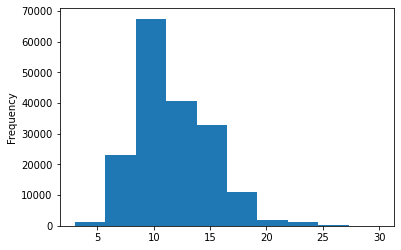

In [13]:
train_df.total_lines.plot.hist()

# **Get list of sentences**

In [14]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
train_sentences[:14]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make numeric labels(ML models requires numeric labels):
To encode labels, we will use sckit-learn's one hot enconder and label encoder.

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
# Label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_encoded

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes names from the label encoder instances
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# **Creating a series of model experiments**

## Model 0: Baseline model

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("Tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('Tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions on model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
# Let's import help functions to further evaluate our predictions
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-06 12:50:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2022-12-06 12:50:29 (14.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results, compare_historys

baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Preparing our data for deep sequence models

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
# Let's write some codes to know the average length of words(tokens) in our training sentences
sent_len = [len(sentences.split()) for sentences in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len

26.338269273494777

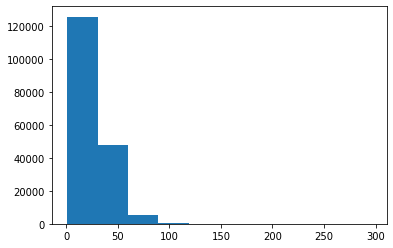

In [26]:
# Let's check the distributions
import matplotlib.pyplot as plt
plt.hist(sent_len); 

In [27]:
# Let's use numpy percentile to look for sentences that cover 95% of the words(tokens) length
output_seq_len = [np.percentile(sent_len, 95)] # We can make do with sentences with 95% tokens(words) length
output_seq_len

[55.0]

In [28]:
# Let's check the max sentences length
max(sent_len)

296

# Create text vectorizer

In [29]:
# According to the Pub Med paper, we have 68,000 words(tokens) in our vocabulary
max_tokens = 68000

In [30]:
# Now let's create our text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
    output_sequence_length=55)

In [31]:
# Adapt our text vectorizer to our train sentences
text_vectorizer.adapt(train_sentences)

In [32]:
import random
random_sentence = random.choice(train_sentences)
print(f"Original text: {random_sentence}")
print(f"\nLength of text: {len(random_sentence)}")
print(f"\nLength of words: {len(random_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([random_sentence])}")

Original text: in the slb group , pi , gi , and pd values increased significantly ( p < @ ) .

Length of text: 78

Length of words: 20

Vectorized text: [[    5     2 24577    13  2439  1832     3   868   334    96    39    14
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [33]:
# Using the get_vocabulary() method find the number of words in our vocabulary
rct_20k_get_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in our vocab: {len(rct_20k_get_vocab)}")
print(f"\n5 most common words in our vocab: {rct_20k_get_vocab[:5]}")
print(f"\n5 least common words in our vocab: {rct_20k_get_vocab[-5:]}")

Number of words in our vocab: 64841

5 most common words in our vocab: ['', '[UNK]', 'the', 'and', 'of']

5 least common words in our vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

# Create custom text embedding

In [35]:
token_embed = layers.Embedding(input_dim = max_tokens,
                               output_dim = 128,
                               name = "token_embeddings")

In [36]:
print(f"Sentence before vectorization: {random_sentence}")
print(f"\nLength of random sentence: {len(random_sentence)}")
print(f"\nLength of words in random sentence: {len(random_sentence.split())}")
print(f"\nVectorized sentence: {text_vectorizer([random_sentence])}")
print(f"\nEmbedded sentence: {token_embed(text_vectorizer([random_sentence]))}")
print(f"\nEmbedded layer shape: {token_embed(text_vectorizer([random_sentence])).shape}")

Sentence before vectorization: in the slb group , pi , gi , and pd values increased significantly ( p < @ ) .

Length of random sentence: 78

Length of words in random sentence: 20

Vectorized sentence: [[    5     2 24577    13  2439  1832     3   868   334    96    39    14
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded sentence: [[[-0.00168028  0.04480517 -0.04308144 ... -0.00172492 -0.00506506
   -0.01963282]
  [ 0.01439767  0.01020003 -0.00255623 ... -0.01007793  0.02626086
    0.04235351]
  [ 0.00957991 -0.02688544 -0.03213163 ... -0.01085439 -0.01466126
   -0.01021521]
  ...
  [-0.03663852  0.03432877 -0.01464568 ...  0.03396087 -0.0088421
    0.04413645]
  [-0.03663852  0.03432877 -0.01464568 ...  0.03396087 -0.0088421
    0.04413645]
  [-0.03663852  

# Create datasets(as fast as possible)

In [37]:
train_datasets = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_datasets = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_datasets = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_datasets

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
train_datasets = train_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
val_datasets = val_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
test_datasets = test_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
train_datasets

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [39]:
# Creating datasets using label encoded 
train_datasets_1 = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
val_datasets_1 = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
test_datasets_1 = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_encoded))
train_datasets_1

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [40]:
# Prefect our label encoded datasets
train_datasets_1 = train_datasets_1.batch(32).prefetch(tf.data.AUTOTUNE)
val_datasets_1 = val_datasets_1.batch(32).prefetch(tf.data.AUTOTUNE)
test_datasets_1 = test_datasets_1.batch(32).prefetch(tf.data.AUTOTUNE)
train_datasets_1

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model 1: Conv1D with token embeddings

In [41]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
vectorizer = text_vectorizer(inputs)
embedded = token_embed(vectorizer)
x = layers.Conv1D(64, kernel_size = 5, padding= "same", name = "conv1d_layer")(embedded)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation= "softmax", name = "output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs, name= "model_1_Conv1D")

In [42]:
# Compile the model
model_1.compile(loss= "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_model_1 = model_1.fit(train_datasets,
                              epochs = 5,
                              steps_per_epoch = int(0.1 * len(train_datasets)),
                              validation_data = val_datasets,
                              validation_steps = int(0.1 * len(val_datasets)))

Epoch 1/5
562/562 [==============================] - 8s 9ms/step - loss: 0.9005 - accuracy: 0.6425 - val_loss: 0.6718 - val_accuracy: 0.7420
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6547 - accuracy: 0.7558 - val_loss: 0.6293 - val_accuracy: 0.7643
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6209 - accuracy: 0.7720 - val_loss: 0.5983 - val_accuracy: 0.7716
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5948 - accuracy: 0.7831 - val_loss: 0.5795 - val_accuracy: 0.7829
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5996 - accuracy: 0.7851 - val_loss: 0.5717 - val_accuracy: 0.7975


In [43]:
model_1.summary()

Model: "model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embeddings (Embedding  (None, 55, 128)          8704000   
 )                                                               
                                                                 
 conv1d_layer (Conv1D)       (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                    

In [44]:
# Evaluate on the whole validation datasets
model_1.evaluate(val_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.5728 - accuracy: 0.7950


[0.5728365778923035, 0.7950152158737183]

In [45]:
# Make predictions
model_1_pred_probs = model_1.predict(val_datasets, val_labels_one_hot)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[5.90627193e-01, 1.55445412e-01, 4.77285162e-02, 1.46380559e-01,
        5.98182864e-02],
       [5.06729841e-01, 3.34179580e-01, 1.18827028e-02, 1.16510056e-01,
        3.06978915e-02],
       [1.99264959e-01, 5.83230099e-03, 1.24037196e-03, 7.93639660e-01,
        2.27511282e-05],
       ...,
       [4.03581980e-05, 1.01803709e-03, 8.09507258e-03, 7.91898201e-05,
        9.90767300e-01],
       [1.56110838e-01, 2.34376341e-01, 1.41979218e-01, 8.21760446e-02,
        3.85357618e-01],
       [1.50935143e-01, 7.82342792e-01, 4.80619557e-02, 4.52137971e-03,
        1.41387293e-02]], dtype=float32)

In [46]:
# Turn predictions probabilities into classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [47]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 79.50152257381174,
 'precision': 0.8012214368425248,
 'recall': 0.7950152257381173,
 'f1': 0.7936983701606162}

## Model 2: Feature extraction with pretrained token embeddings.

In [48]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [49]:
# Check out the samples of our pretrained embeddings
sample_sentence = random.choice(train_sentences)
print(f"Sample sentence: {sample_sentence}")
print(f"\nLength of sample sentence: {len(sample_sentence)}")
print(f"\nLength of words in sample sentence: {len(sample_sentence.split())}")
embed_sentence = tf_hub_embedding_layer([sample_sentence])
print(f"\nSentece after embedding: {embed_sentence[0][:30]}")
print(f"\nEmbedded sentence length: {len(embed_sentence)}")
print(f"\nShape of embed sentence: {embed_sentence.shape}")

Sample sentence: the incidence of ald was highest in individuals who had a high level of occupation .

Length of sample sentence: 84

Length of words in sample sentence: 16

Sentece after embedding: [-0.01031055  0.08304296 -0.00809841 -0.0761607  -0.0069743  -0.0470448
 -0.00866646 -0.06188558  0.04059891  0.0374044   0.07564595  0.0836136
  0.03189113  0.00156685  0.05315244 -0.00513731 -0.05694176 -0.00306948
  0.03098164 -0.05633783 -0.09414957  0.06023163 -0.04442834 -0.03179179
  0.00866139  0.01683432  0.00340282  0.00742084 -0.0406187  -0.03419758]

Embedded sentence length: 1

Shape of embed sentence: (1, 512)


In [50]:
# Now let's build a feature exytraction embedded model
inputs = layers.Input(shape= [], dtype= "string")
embedded_layer = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(embedded_layer)
outputs = layers.Dense(5, activation = "softmax", name= "use_output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs, name="use_model_2")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_2.summary()


Model: "use_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 use_output_layer (Dense)    (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [51]:
# Fit the model
history_model_2 = model_2.fit(train_datasets,
                              epochs= 3,
                              steps_per_epoch = int(0.1 * len(train_datasets)),
                              validation_data = val_datasets,
                              validation_steps = int(0.1 * len(val_datasets)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9174 - accuracy: 0.6499 - val_loss: 0.7973 - val_accuracy: 0.6865
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7703 - accuracy: 0.7011 - val_loss: 0.7573 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7546 - accuracy: 0.7114 - val_loss: 0.7419 - val_accuracy: 0.7148


In [52]:
# Evaluate model
model_2.evaluate(val_datasets)

945/945 [==============================] - 10s 11ms/step - loss: 0.7428 - accuracy: 0.7121


[0.7427949905395508, 0.7120680809020996]

In [53]:
model_2_preds_probs = model_2.predict(val_datasets)
model_2_preds_probs

945/945 [==============================] - 10s 10ms/step


array([[0.43957424, 0.37272757, 0.00260463, 0.1759214 , 0.00917227],
       [0.3505692 , 0.49742317, 0.00443767, 0.14344737, 0.00412264],
       [0.21613075, 0.13583492, 0.02027388, 0.5897237 , 0.03803677],
       ...,
       [0.00187719, 0.00635747, 0.05103503, 0.00114965, 0.9395807 ],
       [0.0037999 , 0.05079923, 0.19793092, 0.00162636, 0.74584365],
       [0.17189421, 0.25442377, 0.48831034, 0.00681067, 0.07856106]],
      dtype=float32)

In [54]:
# Turn model prediction probabilities into classes
model_2_preds = tf.argmax(model_2_preds_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [55]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.20680524294983,
 'precision': 0.7129241431318561,
 'recall': 0.7120680524294982,
 'f1': 0.7093160105501288}

## Model 3: Conv1D with character embeddings

In [56]:
# Create a fuction to split text
def split_chars(text):
  return " ".join(list(text))

In [57]:
split_chars(sample_sentence), len(split_chars(sample_sentence))

('t h e   i n c i d e n c e   o f   a l d   w a s   h i g h e s t   i n   i n d i v i d u a l s   w h o   h a d   a   h i g h   l e v e l   o f   o c c u p a t i o n   .',
 167)

In [58]:
split_chars(random_sentence), len(split_chars(random_sentence))

('i n   t h e   s l b   g r o u p   ,   p i   ,   g i   ,   a n d   p d   v a l u e s   i n c r e a s e d   s i g n i f i c a n t l y   (   p   <   @   )   .',
 155)

In [59]:
# Split data into character level
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [60]:
chars_len = [len(sentence) for sentence in train_sentences]
mean_chars_len = np.mean(chars_len)
mean_chars_len, chars_len[:5]

(149.3662574983337, [281, 137, 111, 65, 209])

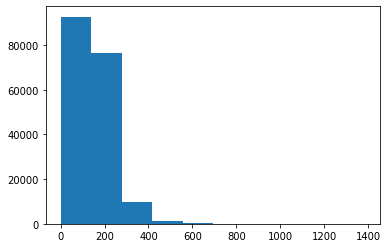

In [61]:
plt.hist(chars_len);

In [62]:
# Let's use numpy percentile to know the sentence with highest of characters
chars_output_sequence_len = int(np.percentile(chars_len, 95))
chars_output_sequence_len

290

In [63]:
from string import punctuation
from string import ascii_lowercase
# From the above output, we can deduce that the average length of characters in each of the training sentence is 290.
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [64]:
max_chars_token = len(alphabet) + 2 # OOV(Out Of Vocabulary or unknown tokens)
max_chars_token

70

In [65]:
# Create a character level token vectorizer instance
chars_vectorizer = TextVectorization(max_tokens= max_chars_token,
                                     output_sequence_length = chars_output_sequence_len,
                                     name = "char_vectorizer")

# Adapt chars vectorizers to our trainning sentences
chars_vectorizer.adapt(train_chars)

In [66]:
# Now that we have adapt our chars vectorizer to our train characters, let's use get vocabulary method to fish out some features
chars_vocab = chars_vectorizer.get_vocabulary()
print(f"Length of chars vocab: {len(chars_vocab)}")
print(f"\n5 common words in chars vocab: {chars_vocab[:5]}")
print(f"\n5 least words in chars vocab: {chars_vocab[-5:]}")

Length of chars vocab: 28

5 common words in chars vocab: ['', '[UNK]', 'e', 't', 'i']

5 least words in chars vocab: ['k', 'x', 'z', 'q', 'j']


In [67]:
#  Let's experiment with our chars_vectorizers
random_chars = random.choice(train_chars)
print(f"Charified text: {random_chars}")
print(f"\nLength of charified text: {len(random_chars)}")
print(f"\nLength of each word in charified text: {len(random_chars.split())}")
vectorized_chars = chars_vectorizer([random_chars])
print(f"\nVectorized chars: {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text: d i s c o n t i n u a t i o n   r a t e s   w e r e   @   %   ,   @   %   ,   @   %   ,   @   %   ,   @   %   ,   @   %   a n d   @   %   (   y e a r s   @ - @   r e s p e c t i v e l y   )   .

Length of charified text: 193

Length of each word in charified text: 69

Vectorized chars: [[10  4  9 11  7  6  3  4  6 16  5  3  4  7  6  8  5  3  2  9 20  2  8  2
   5  6 10 19  2  5  8  9  8  2  9 14  2 11  3  4 21  2 12 19  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0

# Create a charater level embeddings

In [68]:
chars_embed = layers.Embedding(input_dim = max_chars_token,
                               output_dim = 25,
                               name = "chars_embed")

In [69]:
print(f"Charified text: {random_chars}")
embed_chars = chars_embed(chars_vectorizer([random_chars]))
print(f"\nembedded chars: {embed_chars}")
print(f"\nEmbedded chars shape: {embed_chars.shape}")

Charified text: d i s c o n t i n u a t i o n   r a t e s   w e r e   @   %   ,   @   %   ,   @   %   ,   @   %   ,   @   %   ,   @   %   a n d   @   %   (   y e a r s   @ - @   r e s p e c t i v e l y   )   .

embedded chars: [[[ 0.02849013  0.03911891  0.01561895 ...  0.01301369 -0.00498489
    0.0492486 ]
  [-0.0429543   0.03582114 -0.0154429  ... -0.03685337 -0.03692391
   -0.01875645]
  [-0.03055502  0.00043584  0.04023335 ...  0.02060673  0.00162423
   -0.04516464]
  ...
  [-0.01165741 -0.0314309  -0.03175117 ... -0.04460311  0.00672815
   -0.04195106]
  [-0.01165741 -0.0314309  -0.03175117 ... -0.04460311  0.00672815
   -0.04195106]
  [-0.01165741 -0.0314309  -0.03175117 ... -0.04460311  0.00672815
   -0.04195106]]]

Embedded chars shape: (1, 290, 25)


In [70]:
# Build model
inputs = layers.Input(shape=(1,), dtype = tf.string)
char_vector = chars_vectorizer(inputs)
char_embed = chars_embed(char_vector)
x = layers.Conv1D(64, kernel_size = 5, padding= "same", activation= "relu")(char_embed)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation= "softmax", name= "output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs, name="chars_conv1D_model")

# Compile the model
model_3.compile(loss= "categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ["accuracy"])

# Summarize the model
model_3.summary()

Model: "chars_conv1D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 chars_embed (Embedding)     (None, 290, 25)           1750      
                                                                 
 conv1d (Conv1D)             (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 output_layer (Dense)        (None, 5)          

In [71]:
# Let's create a prefectched datasets for our character level data to enable efficient model fitting.
# Create char datasets
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_chars_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [72]:
# Let's fit the model
history_model_3 = model_3.fit(train_chars_dataset,
            epochs = 3,
            steps_per_epoch= int(0.1 * len(train_chars_dataset)),
            validation_data = val_chars_dataset,
            validation_steps = int(0.1 * len(val_chars_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2656 - accuracy: 0.4799 - val_loss: 1.0561 - val_accuracy: 0.5795
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0145 - accuracy: 0.5972 - val_loss: 0.9319 - val_accuracy: 0.6253
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9159 - accuracy: 0.6418 - val_loss: 0.8617 - val_accuracy: 0.6712


In [73]:
model_3.evaluate(val_chars_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8847 - accuracy: 0.6594


[0.8846790194511414, 0.6594399809837341]

In [74]:
model_3_pred_probs = model_3.predict(val_chars_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[0.17416368, 0.35166737, 0.09959193, 0.32905158, 0.04552538],
       [0.15888993, 0.23611295, 0.01745864, 0.5708956 , 0.01664283],
       [0.11135267, 0.1229167 , 0.04033456, 0.70967555, 0.01572054],
       ...,
       [0.0387352 , 0.02169434, 0.07863089, 0.02848242, 0.8324572 ],
       [0.05604789, 0.15877509, 0.37291205, 0.07393428, 0.33833072],
       [0.38818657, 0.49499148, 0.06566931, 0.0461924 , 0.00496019]],
      dtype=float32)

In [75]:
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 2, 1])>

In [76]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.94399576327287,
 'precision': 0.6594020292084175,
 'recall': 0.6594399576327287,
 'f1': 0.6511163308033616}

## Model 4: Combining pretrained token embeddings and character embeddings(hybrid embeddings)

In [77]:
from typing_extensions import Concatenate
# Set up token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string)
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation= "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name= "token_embedded_layer")

# Set up character embeddings
char_inputs = layers.Input(shape=(1,), dtype = tf.string)
char_vector = chars_vectorizer(char_inputs)
char_embed = chars_embed(char_vector)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25,name= "bi_lstm_layer"))(char_embed)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name = "char_model")

# Concatenate token and char models
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# Set a drop out
dropout_layer = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu", name="combined_dense_output")(dropout_layer)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation= "softmax", name="concat_output_layer")(final_dropout)

# Construct model with char and token inputs
model_4 = tf.keras.Model([token_model.input, char_model.input],
                         output_layer,
                         name= "model_4_concat")

In [78]:
model_4.summary()

Model: "model_4_concat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_5[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_4[0][0]']   

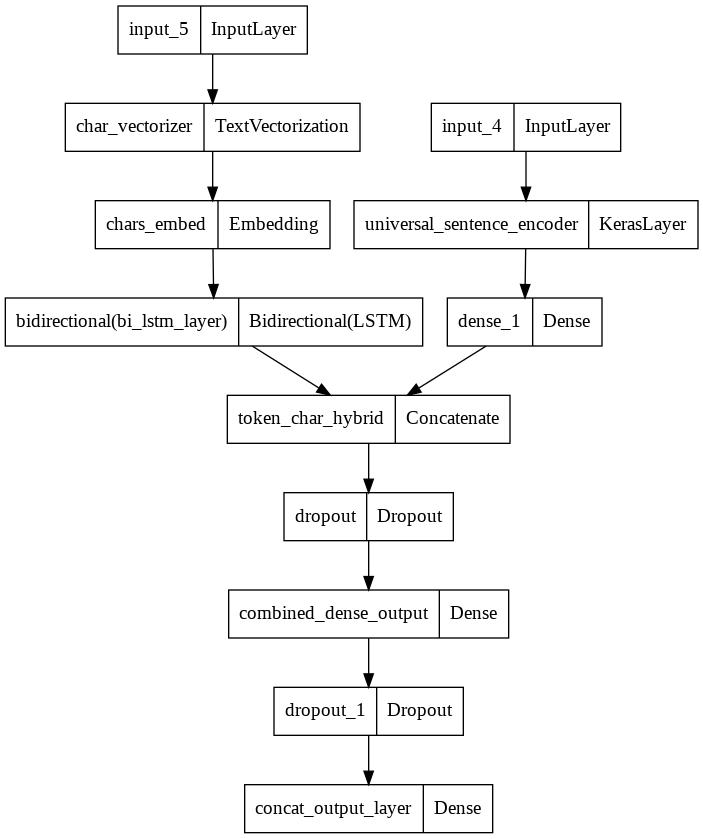

In [79]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [80]:
# Compile the model 
model_4.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Combine token and charater data into tf.data datasets

In [81]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_label = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_label))

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do same for validation datasets
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_label = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_label))

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [82]:
train_token_char_dataset, val_token_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [83]:
# Now let's fit our model
history_model_4 = model_4.fit(train_token_char_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_token_char_dataset)),
                              validation_data = val_token_char_dataset,
                              validation_steps = int(0.1 * len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 25s 38ms/step - loss: 0.9798 - accuracy: 0.6089 - val_loss: 0.7795 - val_accuracy: 0.7011
Epoch 2/3
562/562 [==============================] - 19s 35ms/step - loss: 0.7986 - accuracy: 0.6927 - val_loss: 0.7221 - val_accuracy: 0.7287
Epoch 3/3
562/562 [==============================] - 19s 35ms/step - loss: 0.7706 - accuracy: 0.7061 - val_loss: 0.6924 - val_accuracy: 0.7410


In [84]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6955 - accuracy: 0.7332


[0.6955434679985046, 0.7331854701042175]

In [85]:
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs

945/945 [==============================] - 20s 20ms/step


array([[4.4116423e-01, 3.1800660e-01, 3.2085951e-03, 2.3086336e-01,
        6.7571993e-03],
       [3.5138494e-01, 4.6920192e-01, 3.7711826e-03, 1.7364305e-01,
        1.9987987e-03],
       [2.4466172e-01, 5.1137611e-02, 1.4403410e-02, 6.7792279e-01,
        1.1874428e-02],
       ...,
       [4.4049026e-04, 5.9465505e-03, 5.8047041e-02, 1.7950025e-04,
        9.3538642e-01],
       [7.0137233e-03, 3.9743587e-02, 2.0376331e-01, 3.9894427e-03,
        7.4548995e-01],
       [3.5373393e-01, 3.8956565e-01, 1.9992824e-01, 2.9668367e-02,
        2.7103778e-02]], dtype=float32)

In [86]:
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [87]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.31854892095856,
 'precision': 0.7330744177140472,
 'recall': 0.7331854892095856,
 'f1': 0.7302181167096032}

## Model 5: Transfer learning with pre-trained token embedding + characters embedding + positional embeddings.

# Create positional embeddings

In [88]:
train_df[:5]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [89]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

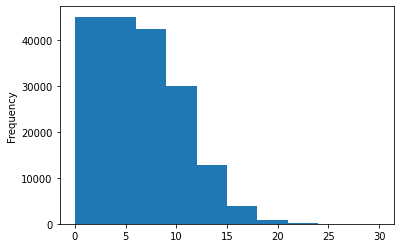

In [90]:
# Check the distribution of our line number
train_df.line_number.plot.hist()

In [91]:
# From our distribution, we can tell that most of our value falls between 0 and 15, so we can set our depth of line number to 15
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)

train_line_number_one_hot, train_line_number_one_hot.shape

(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 15]))

In [92]:
val_line_number_one_hot

<tf.Tensor: shape=(30212, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [93]:
# Let's create one hot tensor embeddings for total lines 
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

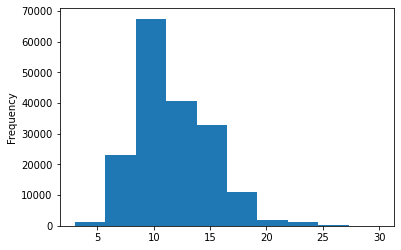

In [94]:
# Let's check the distribution of total lines
train_df.total_lines.plot.hist()

In [95]:
# From the distribution we can deduce that most of our value falls between 0 and 20, let's use percentile method to confirm our claim.
np.percentile(train_df["total_lines"], 98)

20.0

In [96]:
# So we can use 20 as our depth when creating one hot tensor for total lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [97]:
val_total_lines_one_hot

<tf.Tensor: shape=(30212, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

### Build a tribrid embeddings model

In [98]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = chars_vectorizer(char_inputs)
char_embeddings = chars_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)
     

In [99]:
model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

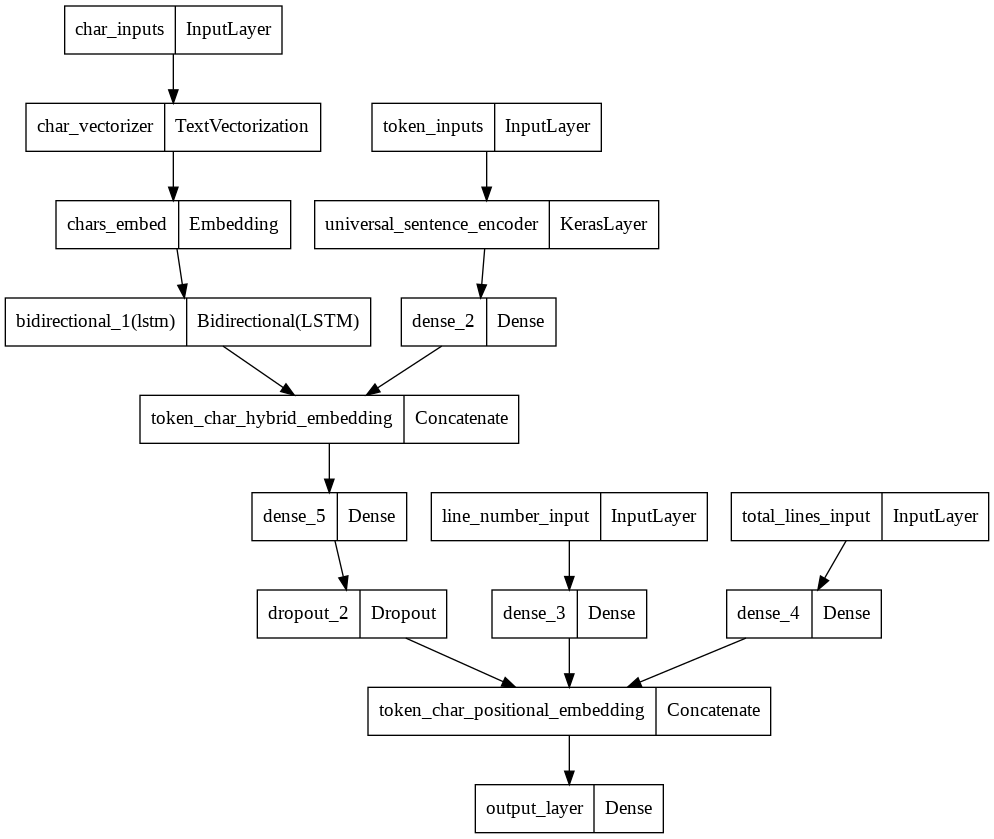

In [100]:
# Plot our model 
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [101]:
# Check layers of our model that is trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f99ad5be730> True
<keras.engine.input_layer.InputLayer object at 0x7f99ad5be3d0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f99865b7580> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f999a31b610> False
<keras.layers.core.embedding.Embedding object at 0x7f98a42d02e0> True
<keras.layers.core.dense.Dense object at 0x7f99ad5be5e0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7f99ad534610> True
<keras.layers.merging.concatenate.Concatenate object at 0x7f99ad4c8c10> True
<keras.engine.input_layer.InputLayer object at 0x7f99ad51c2b0> True
<keras.engine.input_layer.InputLayer object at 0x7f99ad56a250> True
<keras.layers.core.dense.Dense object at 0x7f99ad4e4ca0> True
<keras.layers.core.dense.Dense object at 0x7f99ad515be0> True
<keras.layers.core.dense.Dense object at 0x7f99ad53ce80> True
<keras.layers.regularization.dropout.Dropout object at 0x7f99ad5158e0> True
<keras.layers

# Create tribrid embeddings datasets and fit tribrid model

In [103]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [104]:
# Compile the model
model_5.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [105]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_pos_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_pos_char_token_dataset,
                              validation_steps = int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 26s 39ms/step - loss: 1.1001 - accuracy: 0.7188 - val_loss: 0.9801 - val_accuracy: 0.8062
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9687 - accuracy: 0.8137 - val_loss: 0.9484 - val_accuracy: 0.8281
Epoch 3/3
562/562 [==============================] - 20s 35ms/step - loss: 0.9500 - accuracy: 0.8243 - val_loss: 0.9391 - val_accuracy: 0.8321


In [106]:
# Evaluate model
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 27s 29ms/step - loss: 0.9376 - accuracy: 0.8331


[0.9375562071800232, 0.8331126570701599]

In [107]:
# Make predictions
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

945/945 [==============================] - 21s 21ms/step


array([[0.45846298, 0.13485901, 0.01151026, 0.37666467, 0.01850314],
       [0.53234243, 0.10520124, 0.04997445, 0.3029264 , 0.00955552],
       [0.26859352, 0.10881855, 0.12712672, 0.41571507, 0.07974613],
       ...,
       [0.04184232, 0.10177517, 0.03985272, 0.03435542, 0.7821744 ],
       [0.03012766, 0.26548076, 0.08253033, 0.02703466, 0.59482664],
       [0.21305604, 0.5782049 , 0.11149088, 0.03597493, 0.0612733 ]],
      dtype=float32)

In [108]:
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [109]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.31126704620681,
 'precision': 0.832285599244386,
 'recall': 0.833112670462068,
 'f1': 0.8321348501056913}

# Compare Results

In [118]:
import pandas as pd
all_model_results = pd.DataFrame({
    "baseline_model": baseline_results,
    "Conv1D_model": model_1_results,
    "Feature_extraction_model": model_2_results,
    "Conv1D_embeddded_model": model_3_results,
    "hybrid_embedding_model": model_4_results,
    "tribid_embeddings_model": model_5_results
})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline_model,72.183238,0.718647,0.721832,0.698925
Conv1D_model,79.501523,0.801221,0.795015,0.793698
Feature_extraction_model,71.206805,0.712924,0.712068,0.709316
Conv1D_embeddded_model,65.943996,0.659402,0.659440,0.651116
hybrid_embedding_model,73.318549,0.733074,0.733185,0.730218
tribid_embeddings_model,83.311267,0.832286,0.833113,0.832135


In [119]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline_model,0.721832,0.718647,0.721832,0.698925
Conv1D_model,0.795015,0.801221,0.795015,0.793698
Feature_extraction_model,0.712068,0.712924,0.712068,0.709316
Conv1D_embeddded_model,0.659440,0.659402,0.659440,0.651116
hybrid_embedding_model,0.733185,0.733074,0.733185,0.730218
tribid_embeddings_model,0.833113,0.832286,0.833113,0.832135


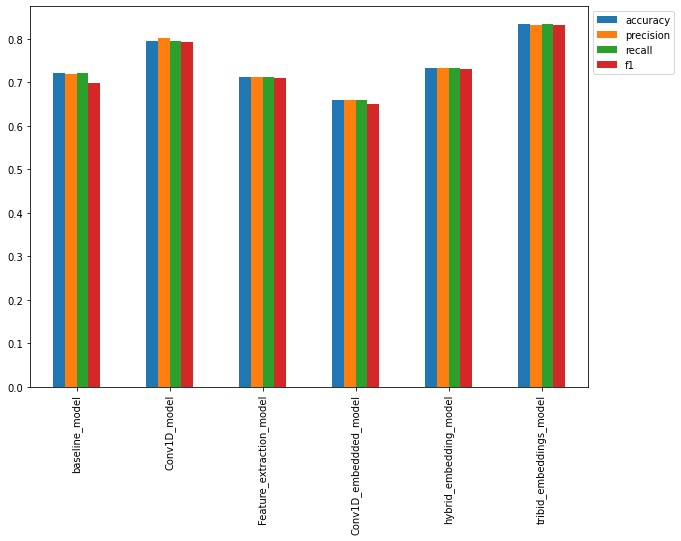

In [120]:
from mpl_toolkits.mplot3d.axes3d import Bbox
all_model_results.plot(kind= "bar", figsize=(10,7)).legend(bbox_to_anchor = (1.0,1.0))

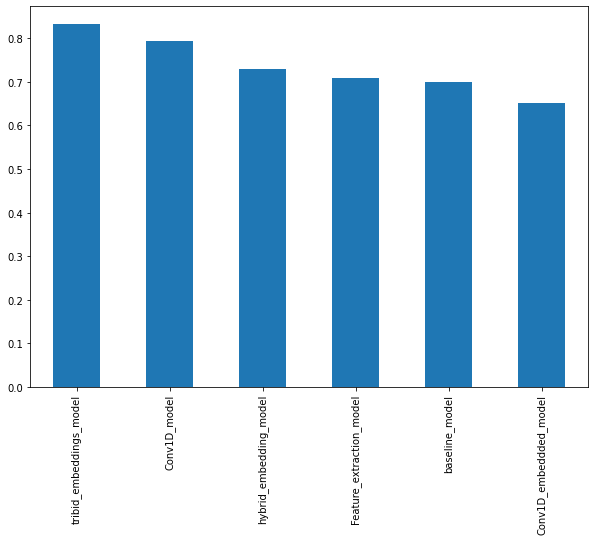

In [121]:
# Sort by f1
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind= "bar", figsize=(10, 7))

# Save and load best performing model

In [122]:
model_5.save("skimlit_tribid_model")

In [125]:
from google.colab import files
files.download("skimlit_tribid_model")
     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [126]:
loaded_model = tf.keras.models.load_model("skimlit_tribid_model")
loaded_model

In [130]:
# Make predictions with the loaded model on validation dataset
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset)
loaded_pred_probs

945/945 [==============================] - 23s 25ms/step


array([[0.45846298, 0.13485901, 0.01151025, 0.37666467, 0.01850314],
       [0.5323424 , 0.10520127, 0.04997445, 0.3029264 , 0.00955552],
       [0.2685935 , 0.10881853, 0.12712672, 0.41571507, 0.07974613],
       ...,
       [0.04184232, 0.10177517, 0.03985272, 0.03435542, 0.7821744 ],
       [0.03012765, 0.26548076, 0.08253032, 0.02703466, 0.5948266 ],
       [0.21305604, 0.5782049 , 0.11149088, 0.03597493, 0.0612733 ]],
      dtype=float32)

In [131]:
loaded_preds = tf.argmax(loaded_pred_probs, axis = 1)
loaded_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [132]:
loaded_model_results = calculate_results(val_labels_encoded, loaded_preds)
loaded_model_results

{'accuracy': 83.31126704620681,
 'precision': 0.832285599244386,
 'recall': 0.833112670462068,
 'f1': 0.8321348501056913}

In [133]:
# Compare loaded and original model
model_5_results == loaded_model_results

True

In [134]:
!cp skimlit_tribid_model -r /content/drive/MyDrive/tensorflow

# Evaluate model on test datasets

In [136]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [137]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]
     

942/942 [==============================] - 21s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

In [138]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.83391405342626,
 'precision': 0.8271211860861042,
 'recall': 0.8283391405342625,
 'f1': 0.8272453037561313}

# Find the most wrong

In [139]:
test_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [145]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [142]:
%%time
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 12.3 s, sys: 1.07 s, total: 13.4 s
Wall time: 11.8 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RE

In [144]:
# Cross check our test dataframe
test_df[:10]

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8
6,RESULTS,multivariable analyses revealed that patients ...,6,8
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12


In [147]:
# Create prediction enriched dataframe
test_df["prediction"] = test_pred_classes
test_df["pred_probs"] = tf.reduce_max(test_pred_probs, axis = 1)
test_df["preds_probs"] = tf.argmax(test_pred_probs, axis = 1)
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df

,target,text,line_number,total_lines,prediction,pred_probs,preds_probs,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.489467,3,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.320017,3,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.814842,2,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.615428,2,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.714414,4,True
...,...,...,...,...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17,RESULTS,0.839706,4,True
30131,RESULTS,there were no statistically significant betwee...,14,17,RESULTS,0.741306,4,True
30132,RESULTS,there was no significant association between s...,15,17,RESULTS,0.710769,4,True
30133,RESULTS,no adverse effects were reported .,16,17,RESULTS,0.759379,4,True


In [149]:
test_df["correct"].value_counts()

True     24962
False     5173
Name: correct, dtype: int64

In [153]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_probs", ascending= False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_probs,preds_probs,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.932766,2,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.932122,3,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.929954,2,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.918217,0,False
835,BACKGROUND,to assess the temporal patterns of late gastro...,0,11,OBJECTIVE,0.914855,3,False
...,...,...,...,...,...,...,...,...
12456,RESULTS,icd patients were randomized @:@ to automatic ...,1,13,METHODS,0.833454,2,False
12137,RESULTS,exposure to ppis was categorized according to ...,5,16,METHODS,0.833038,2,False
13490,RESULTS,data were analyzed at baseline and longitudina...,4,14,METHODS,0.832770,2,False
3647,RESULTS,three ree measurements were performed in each ...,4,12,METHODS,0.832616,2,False


In [154]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob,preds_probs, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9327656626701355, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9321224689483643, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9299539923667908, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9182167649269104, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9148552417755127, Line number: 0, Total lines: 11

Text:
to assess the temporal patterns of late gastrointestinal ( gi ) and genitourinary ( gu ) radiotherapy toxicity and resolution rates in a randomised controlled trial ( all-ireland coopera